In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path


mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [2]:
from torch.utils.data import Dataset, DataLoader, Sampler
# without transformation at the batch step
class SimpleDataset(Dataset):
    def __init__(self, x, y, e):
        self.data = x
        self.targets = y
        self.label = e
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        return img, target, label
        
        
    def __len__(self):
        return len(self.data)
    
#     def get_mean_std(self):            
#         mean = np.mean(self.data[:,self.covlist], axis = 0)
#         std = np.std(self.data[:,self.covlist], axis = 0)
# #         print(std)
#         # set covariates with std =0 has std = mean
#         std[std==0] = mean[std==0]+1e-3

#         return mean, std

In [3]:
class SimpleDataset_trans(Dataset):
    def __init__(self, x, y, e, transform=False, covlist = None, mean=0, std = 1):
        self.data = x
        self.targets = y
        self.label = e
        self.transform = transform
        self.covlist = covlist
        if not self.covlist:
            self.covlist = np.arange(self.data.shape[1])
        
        if self.transform:
            self.mean, self.std = mean, std
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        if self.transform:
            return (img[self.covlist]-self.mean)/self.std, target, label
        else:
            return img, target, label
        
        

    def __len__(self):
        return len(self.data)

## Cox-gompertz linear setting

Load framingham dataset

In [4]:
from data.simulation import simulation_cox_weibull_all

file_path = '/data/zidi/framingham/'
result_path_root = '/data/zidi/ACSurv/results/toy'
# file_path = '/Users/ZidiXiu/Dropbox/Research/framingham/data/'
# result_path_root = "/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results"+'/toy'

cut_bound = 6
df= simulation_cox_weibull_all(n=20000, censor_bound=0)

# change to non-ohe 
cat0_level = df['ohe'][0]
cat1_level = df['ohe'][1]

# cat0 = 0*df['x'][:,2] + 1*df['x'][:,3]+ 2*df['x'][:,4]+ 3*df['x'][:,5]
cat0 = np.sum(np.array([level*df['x'][:, 2+level] for level in range(cat0_level)]),0).reshape(-1,1)
cat1 = np.sum(np.array([level*df['x'][:, 2+cat0_level+level] for level in range(cat1_level)]),0).reshape(-1,1)


df['x'] = np.concatenate((df['x'][:,df['cts_idx']], cat0, cat1), axis=1)
nsamples, ncov= df['x'].shape

cov_list = np.array(['AGE','RANDON', 'cat0','cat1'])
cts_idx = df['cts_idx']
cts_var = cov_list[cts_idx]
cat_idx = np.setdiff1d(np.arange(ncov), cts_idx)
cat_var = cov_list[cat_idx]

np.mean(df['e'])

1.0

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<AxesSubplot:ylabel='count'>, array([2, 3]))

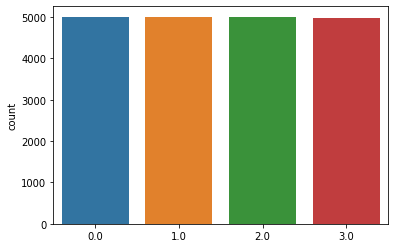

In [5]:
sns.countplot(df['x'][:,-2]), cat_idx

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

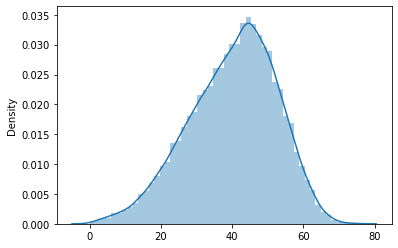

In [6]:
sns.distplot(df['T'])

In [7]:
from data.utils import *
nsamples, ncov= df['x'].shape
np.random.seed(123)
all_idx = np.arange(nsamples)
all_idx = np.random.permutation(all_idx)
train_idx = all_idx[:int(2*nsamples/3)]
valid_idx = all_idx[int(2*nsamples/3):]

train = formatted_data(df['x'], df['t'], df['e'], train_idx)
valid = formatted_data(df['x'], df['t'], df['e'], valid_idx)

del df

observed fold:1.0
observed fold:1.0


### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [8]:
def landmarks_init(dataset, m, cts_var=None, cts_idx = None, device='cpu'):
    '''
    continuous_idx: 
    
    '''
    if type(cts_var) == type(None):
        cts_idx = np.arange(dataset['x'].shape[1])
        cts_var = cts_idx
    
    # creat landmarks as traditional dictionary
    x_landmarks = {}

    [x_landmarks.update({var: torch.tensor(np.percentile(dataset['x'][:,c_idx], np.linspace(0,100,m))).to(device).contiguous()}) for c_idx, var in zip(cts_idx, cts_var)]

    # save the initialized landmarks as a torch parameter dictionary
    x_emb_landmarks = nn.ParameterDict({})
    for var in cts_var:
        m = len(x_landmarks[var])
        x_emb_landmark = torch.eye(m)
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_landmark)})
        x_emb_landmarks.update(new_dict)
        
    return x_landmarks, x_emb_landmarks

# x_landmarks, x_emb_landmarks = landmarks_init(train, m, continuous_variables)
# x_landmarks, x_emb_landmarks

In [9]:
# x_landmarks, x_emb_landmarks = landmarks_init(train, 10, cts_var, cts_idx, device='cuda')
# x_landmarks, x_emb_landmarks

In [10]:
# x_landmarks.keys(), x_emb_landmarks.keys()

### Linear Interpolation for continuous variables

$x_b \le x < x_{b+1}$, $\text{emb}(x) = \text{emb}(x_b) + \frac{\text{emb}(x_{b+1}) - \text{emb}(x_b)}{x_{b+1}-x_b}(x-x_{b})$

In [11]:

# def linear_interpolation_np(x, x_landmarks):
#     # apply numpy package
#     m = len(x_landmarks)
#     x_emb_landmarks = np.eye(m)
#     # returns index
#     # a[i-1] < v <= a[i]
#     indx = np.searchsorted(x_landmarks, x)
#     # combine the first two indices, and the last two indices
#     # to include the unobserved minimum and maximum value
#     # combines [0,1], and [m-1, m]
#     indx = np.where(indx==0, 1, indx)
#     indx = np.where(indx==m, m-1, indx)

#     # linear interpolation
#     def helper(idx, x0):
#         return x_emb_landmarks[idx-1] + (x0-x_landmarks[idx-1])*(x_emb_landmarks[idx] - x_emb_landmarks[idx-1])/(x_landmarks[idx]-x_landmarks[idx-1])
    
#     out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(np.vstack(out))


def linear_interpolation_var(x, x_landmark, x_emb_landmark):
    # written for torch
    # returns index
    # a[i-1] < v <= a[i]
    indx = torch.searchsorted(x_landmark, x)
    # combine the first two indices, and the last two indices
    # to include the unobserved minimum and maximum value
    # combines [0,1], and [m-1, m]
    indx = torch.where(indx==0, 1, indx)
    indx = torch.where(indx==m, m-1, indx)

    # linear interpolation
    def helper(idx, x0):
        return x_emb_landmark[idx-1] + (x0-x_landmark[idx-1])*(x_emb_landmark[idx] - x_emb_landmark[idx-1])/(x_landmark[idx]-x_landmark[idx-1])
    
    out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(torch.vstack(out))
    return torch.vstack(out)

In [12]:
def cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var=None, cts_idx=None):
    
#     m = len(x_landmarks[0])
    if type(cts_var) == type(None):
        cts_var = x_landmarks.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cts_idx, cts_var):
        m = len(x_landmarks[var])
        cur_emb = linear_interpolation_var(x[:,c_idx], x_landmarks[var], x_emb_landmarks[var])
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
#     return torch.cat(res, 1)

In [13]:
# cts_interpolation(torch.tensor(train['x'][:20]).float(), x_landmarks, x_emb_landmarks, cts_var, cts_idx, device)

In [14]:
    '''
    To handle missingness, indicating by a masking matrix
    1 for observed, 0 for censored
    
    If missing, no need to interpolation at this location
    '''

# def cts_interpolation_mask(x, x_landmarks, x_emb_landmarks, continuous_variables=None, device='cpu'):
#     '''
#     To handle missingness, indicating by a masking matrix
#     1 for observed, 0 for censored
    
#     To be completed
#     '''
#     m = len(x_landmarks[0])
#     if type(continuous_variables) == type(None):
#         continuous_variables = np.arange(len(x_landmarks))
#     # find values variable by variable
#     res = []
#     for var in continuous_variables:
#         cur_emb = linear_interpolation_var(x[:,var], x_landmarks[var], x_emb_landmarks[var], device=device)
#         # reshape to dimension [batch_size, 1, m]
#         res.append(cur_emb.view(-1,1,m))
        
#     return torch.cat(res, 1)
# #     return torch.cat(res, 1)

'\nTo handle missingness, indicating by a masking matrix\n1 for observed, 0 for censored\n\nIf missing, no need to interpolation at this location\n'

In [15]:
# x_cts_emb = cts_interpolation(torch.tensor(train['x'][:10]), x_landmarks, x_emb_landmarks, continuous_variables)
# x_cts_emb

### Embedding categorical variables

Embed each level ($l$) of categorical variable, i.e., mapping each digit label to a length-m embedding vector, the $l$-th row of the embedding matrix.

In [16]:
# save variable name and levels as a dictionary
# x_levels = {}
# [x_levels.update({var:len(np.unique(df['x'][:,var]))}) for var in categorical_variables]

def level_init(dataset, m, cat_var=None, cat_idx=None):
#     if type(categorical_variables)==type(None):
#         categorical_variables = np.arange(len(x_levels))
    x_levels = {} 
    [x_levels.update({var:len(np.unique(dataset['x'][:,c_idx]))}) for c_idx, var in zip(cat_idx, cat_var)]
    # save the initialized landmarks as a dictionary
    x_emb_levels = nn.ParameterDict({})
    for var in cat_var:
        level = x_levels[var]
        # randomly pick one position as 1
        idx = np.random.choice(m)
        x_emb_level = torch.zeros(level, m)
#         x_emb_level = F.softmax(torch.rand(level, m),dim=-1)

        for l in range(level):
            idx = np.random.choice(m)
            x_emb_level[l, idx] = 1.0
    
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_level)})
        x_emb_levels.update(new_dict)
    return x_levels, x_emb_levels

In [17]:
# save variable name and levels as a dictionary
# x_levels = {}
# [x_levels.update({var:len(np.unique(df['x'][:,var]))}) for var in categorical_variables]

# def level_init(dataset, m, cat_var=None, cat_idx=None):
# #     if type(categorical_variables)==type(None):
# #         categorical_variables = np.arange(len(x_levels))
#     x_levels = {} 
#     [x_levels.update({var:len(np.unique(dataset['x'][:,c_idx]))}) for c_idx, var in zip(cat_idx, cat_var)]
#     # save the initialized landmarks as a dictionary
#     x_emb_levels = nn.ParameterDict({})
#     for var in cat_var:
#         level = x_levels[var]
#         # randomly pick one position as 1
#         idx = np.random.choice(m)
#         x_emb_level = torch.nn.Embedding(level, m)
    
#         new_dict = nn.ParameterDict({var:x_emb_level})
#         x_emb_levels.update(new_dict)
#     return x_levels, x_emb_levels

In [18]:
# x_levels, x_emb_levels = level_init(train, 10, cat_var, cat_idx)
# x_levels, x_emb_levels

In [19]:
def cat_interpolation(x, x_emb_levels, cat_var=None, cat_idx = None):
    if type(cat_var) == type(None):
        cat_var = x_emb_levels.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cat_idx, cat_var):
        cur_emb = x_emb_levels[var][x[:,c_idx].long()]
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
    

Linear interpolation batch by batch

In [20]:
# m = 10
# device='cpu'
# # Initiate landmarks with trainable paramters
# x_landmarks, x_emb_landmarks = landmarks_init(train, m, cts_var, cts_idx, device)
# x_levels, x_emb_levels = level_init(train, m, cat_var, cat_idx, device)

# 
# 
def cov_embedding(x, m, cts_var=None, cts_idx = None, x_landmarks=None, x_emb_landmarks=None,
                  cat_var=[], cat_idx = [], x_levels=None, x_emb_levels=None):
    '''
    Do the transformation within each minibatch

    m: length of the embedding vector for each covariates

    cts_var: list of the names of continuous variables
    cat_var: list of the names of categorical variables

    x_landmarks: dictionary with continuous names as keys, and the percentile landmarks as items
    x_emb_landmarks: dictionary with continuous names as keys, and the embedding landmarks as items

    x_levels: dictionary with categorical names as keys, and the number of levels per covariate as items
    x_emb_levels: dictionary with categorical names as keys, and the embedding vectors as items
    '''
    x_emb = []
    var_list = []
    if type(cts_var) != type(None):
        x_emb.append(cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var, cts_idx))
        var_list.extend(list(x_emb_landmarks.keys()))
        
    if len(cat_var) >0:
        x_emb.append(cat_interpolation(x, x_emb_levels, cat_var, cat_idx))
        var_list.extend(list(x_emb_levels.keys()))
    
    x_emb = torch.cat(x_emb, 1)
#     cur_var_list = torch.cat(var_list)
#     print(var_list)
    return x_emb, var_list
        

In [21]:
# batch_emb, var_list = cov_embedding(torch.tensor(train['x'][:20]).float(), 10, cts_var, cts_idx, x_landmarks, x_emb_landmarks,
#                                     cat_var, cat_idx, x_levels, x_emb_levels)
# batch_emb.shape

In [22]:
len(cat_idx)

2

In [23]:
class Embedding(nn.Module):
    '''
    create embedding paramters
    '''
    def __init__(self, dataset, cts_var, cts_idx, cat_var=[], cat_idx=[], dropout=0.0, m=10, device='cuda'):
        super(Embedding, self).__init__()
        self.m = m
        self.cts_var, self.cts_idx, self.cat_var, self.cat_idx =  cts_var, cts_idx, cat_var, cat_idx
        # Initiate landmarks with trainable paramters
        self.x_landmarks, self.x_emb_landmarks = landmarks_init(dataset, m, cts_var, cts_idx, device)
        if len(cat_idx) > 0:
            self.x_levels, self.x_emb_levels = level_init(dataset, m, cat_var, cat_idx)
        else:
            self.x_levels, self.x_emb_levels = None, None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, mask=None):
        x_emb, var_list = cov_embedding(x.float(), self.m,\
                                        self.cts_var, self.cts_idx, self.x_landmarks, self.x_emb_landmarks,\
                                        self.cat_var, self.cat_idx, self.x_levels, self.x_emb_levels)
        return self.dropout(x_emb)



In [24]:
# class Embedding_simple(nn.Module):
#     '''
#     create embedding paramters
#     '''
#     def __init__(self):
#         super(Embedding, self).__init__()
#         self.embedding = torch.nn.Embedding
#     def forward(self, x, mask=None):
#         x_emb, var_list = cov_embedding(x.float(), self.m,\
#                                         self.cts_var, self.cts_idx, self.x_landmarks, self.x_emb_landmarks,\
#                                         self.cat_var, self.cat_idx, self.x_levels, self.x_emb_levels)
#         return self.dropout(x_emb)



In [25]:

class Linear(nn.Module):
    '''
    create linear combinations for different embedded vectors
    '''
    def __init__(self, dropout):
        super(Linear, self).__init__()
#         self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x_emb):
        # with shape [batch_size, ncov, m]
#         x_emb = x_emb.permute(0,2,1)
        # now it has shape [batch_size, m, ncov]
        # comparing to an image, m is like the channel
        return self.flatten(self.dropout(x_emb))
        
        

In [26]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

    
class DecMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        # reshape to original shape?
        return z
    
# class Embedding(nn.Module):
#     def __init__(self, ncov, z_dim, h_dim=[32,32]):
#         super(Embedding, self).__init__()
#         self.enc = EncEmbedding(input_size=ncov, output_size=z_dim, h_dim=h_dim)
#         self.dec = DecEmbdedding(input_size=z_dim, output_size=ncov, h_dim=h_dim)
#     def forward(self, x, mask=True):
#         z = self.enc(x)
#         rec_x = self.dec(z)
        
#         return z, rec_x

In [27]:
# # with transformation
# ncov = train['x'].shape[1]
# covList = np.arange(ncov)
# mean = np.mean(train['x'], axis=0)
# std = np.std(train['x'], axis=0)

# trainData = SimpleDataset_trans(train['x'], train['t'], train['e'], transform=True, mean=mean, std = std)
# pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
# pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

# validData = SimpleDataset_trans(valid['x'], valid['t'], valid['e'], transform=True, mean=mean, std = std)
# v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# # v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

In [28]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset(train['x'], train['t'], train['e'])
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(valid['x'], valid['t'], valid['e'])
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)


In [29]:
result_path_root

'/data/zidi/ACSurv/results/toy'

In [30]:
m=10
zdim = m
epochs = 1000
device = 'cuda'
model_name = 'emb_only'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(1)


result_path = result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

'''covariate embedding'''
embedding = Embedding(train, cts_var, cts_idx, cat_var, cat_idx, m=m)

'''attention network'''
attention = Linear(dropout=0.1)
'''decoding the embedded vectors'''
decoder = DecMLP(input_size = zdim*ncov, output_size = 1, h_dim=[512, 512])

embedding.to(device)
attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=1e-3)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)

emb_path = result_path+model_name+'_emb.pt'
dec_path = result_path+model_name+'_dec.pt'

print(embedding, attention, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (AGE): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 1)]
      (RANDON): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 1)]
  )
  (x_emb_levels): ParameterDict(
      (cat0): Parameter containing: [torch.cuda.FloatTensor of size 4x10 (GPU 1)]
      (cat1): Parameter containing: [torch.cuda.FloatTensor of size 100x10 (GPU 1)]
  )
  (dropout): Dropout(p=0.0, inplace=False)
) Linear(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.1, inplace=False)
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


Text(0.5, 1.0, 'AGE embedding')

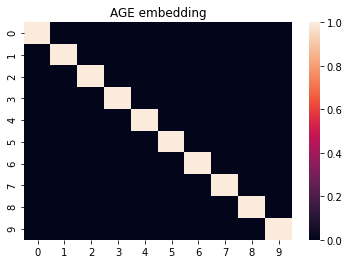

In [31]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

Text(0.5, 1.0, 'RANDON embedding')

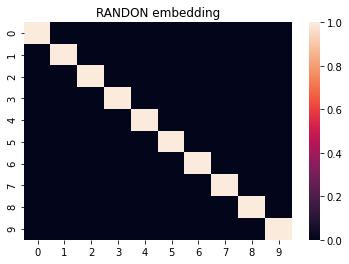

In [32]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

Text(0.5, 1.0, 'CAT0 embedding')

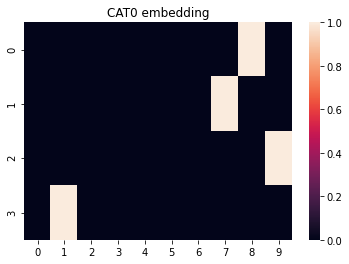

In [33]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

Text(0.5, 1.0, 'CAT1 embedding')

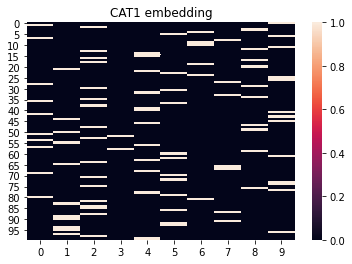

In [34]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

epoch1


<ipython-input-11-8b2dc3ae2521>:26: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/aten/src/ATen/native/BucketizationUtils.h:20.)
  indx = torch.searchsorted(x_landmark, x)


====> Train NLL: 22984145.2642 	 Valid event loss: 11423520.4952 	 censoring loss : 0.0000 	 Improved: *
epoch2
====> Train NLL: 21933701.3212 	 Valid event loss: 10771001.8470 	 censoring loss : 0.0000 	 Improved: *
epoch3
====> Train NLL: 20424391.5480 	 Valid event loss: 9874723.0452 	 censoring loss : 0.0000 	 Improved: *
epoch4
====> Train NLL: 18308235.6166 	 Valid event loss: 8599419.8694 	 censoring loss : 0.0000 	 Improved: *
epoch5
====> Train NLL: 15359675.6396 	 Valid event loss: 6851406.9478 	 censoring loss : 0.0000 	 Improved: *
epoch6
====> Train NLL: 11440601.9323 	 Valid event loss: 4652766.1509 	 censoring loss : 0.0000 	 Improved: *
epoch7
====> Train NLL: 6954619.4378 	 Valid event loss: 2389038.9722 	 censoring loss : 0.0000 	 Improved: *
epoch8
====> Train NLL: 3091231.5575 	 Valid event loss: 954577.5038 	 censoring loss : 0.0000 	 Improved: *
epoch9
====> Train NLL: 1574605.6673 	 Valid event loss: 634350.4131 	 censoring loss : 0.0000 	 Improved: *
epoch10


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


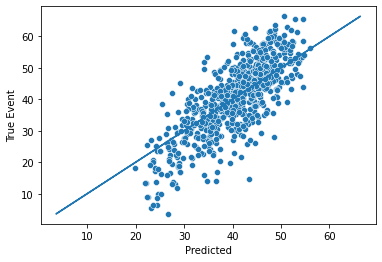

====> Train NLL: 1053247.0834 	 Valid event loss: 428432.7945 	 censoring loss : 0.0000 	 Improved: *
epoch11
====> Train NLL: 780164.7107 	 Valid event loss: 346925.6963 	 censoring loss : 0.0000 	 Improved: *
epoch12
====> Train NLL: 690941.9985 	 Valid event loss: 326878.1017 	 censoring loss : 0.0000 	 Improved: *
epoch13
====> Train NLL: 647823.8238 	 Valid event loss: 317467.2505 	 censoring loss : 0.0000 	 Improved: *
epoch14
====> Train NLL: 649307.2023 	 Valid event loss: 312902.4348 	 censoring loss : 0.0000 	 Improved: *
epoch15
====> Train NLL: 629467.5030 	 Valid event loss: 313858.4072 	 censoring loss : 0.0000 	 Improved:  
epoch16
====> Train NLL: 626726.3012 	 Valid event loss: 302450.6582 	 censoring loss : 0.0000 	 Improved: *
epoch17
====> Train NLL: 617429.1505 	 Valid event loss: 307743.6792 	 censoring loss : 0.0000 	 Improved:  
epoch18
====> Train NLL: 614858.3496 	 Valid event loss: 296058.3698 	 censoring loss : 0.0000 	 Improved: *
epoch19
====> Train NLL: 5

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


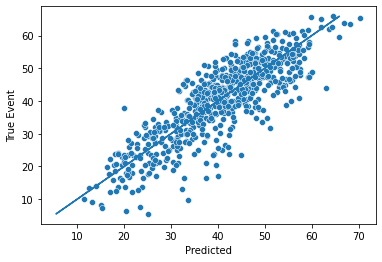

====> Train NLL: 595985.8586 	 Valid event loss: 299451.6732 	 censoring loss : 0.0000 	 Improved:  
epoch21
====> Train NLL: 602748.2223 	 Valid event loss: 295452.0858 	 censoring loss : 0.0000 	 Improved:  
epoch22
====> Train NLL: 587999.1515 	 Valid event loss: 292515.9713 	 censoring loss : 0.0000 	 Improved: *
epoch23
====> Train NLL: 594059.9234 	 Valid event loss: 290980.4807 	 censoring loss : 0.0000 	 Improved: *
epoch24
====> Train NLL: 578024.8824 	 Valid event loss: 286938.4843 	 censoring loss : 0.0000 	 Improved: *
epoch25
====> Train NLL: 569532.8955 	 Valid event loss: 288325.6565 	 censoring loss : 0.0000 	 Improved:  
epoch26
====> Train NLL: 576559.9923 	 Valid event loss: 285375.5952 	 censoring loss : 0.0000 	 Improved: *
epoch27
====> Train NLL: 576797.0349 	 Valid event loss: 288649.1305 	 censoring loss : 0.0000 	 Improved:  
epoch28
====> Train NLL: 579816.6511 	 Valid event loss: 281673.1419 	 censoring loss : 0.0000 	 Improved: *
epoch29
====> Train NLL: 57

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


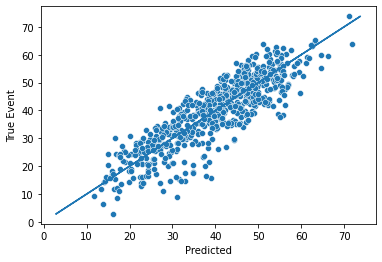

====> Train NLL: 570169.9635 	 Valid event loss: 281107.0670 	 censoring loss : 0.0000 	 Improved: *
epoch31
====> Train NLL: 570605.9082 	 Valid event loss: 279536.4258 	 censoring loss : 0.0000 	 Improved: *
epoch32
====> Train NLL: 563022.2038 	 Valid event loss: 282083.4737 	 censoring loss : 0.0000 	 Improved:  
epoch33
====> Train NLL: 566099.4955 	 Valid event loss: 281837.1952 	 censoring loss : 0.0000 	 Improved:  
epoch34
====> Train NLL: 561787.5626 	 Valid event loss: 281540.0105 	 censoring loss : 0.0000 	 Improved:  
epoch35
====> Train NLL: 565268.9352 	 Valid event loss: 279088.1671 	 censoring loss : 0.0000 	 Improved: *
epoch36
====> Train NLL: 560455.7709 	 Valid event loss: 277566.6290 	 censoring loss : 0.0000 	 Improved: *
epoch37
====> Train NLL: 562644.1631 	 Valid event loss: 278547.4878 	 censoring loss : 0.0000 	 Improved:  
epoch38
====> Train NLL: 555339.0224 	 Valid event loss: 276724.4644 	 censoring loss : 0.0000 	 Improved: *
epoch39
====> Train NLL: 55

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


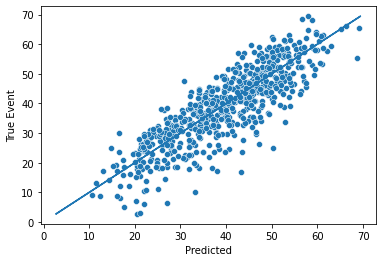

====> Train NLL: 550789.0233 	 Valid event loss: 278129.6623 	 censoring loss : 0.0000 	 Improved:  
epoch41
====> Train NLL: 558089.7889 	 Valid event loss: 276004.3660 	 censoring loss : 0.0000 	 Improved: *
epoch42
====> Train NLL: 556686.9122 	 Valid event loss: 273295.7976 	 censoring loss : 0.0000 	 Improved: *
epoch43
====> Train NLL: 554413.9247 	 Valid event loss: 268253.4682 	 censoring loss : 0.0000 	 Improved: *
epoch44
====> Train NLL: 551772.8021 	 Valid event loss: 272552.4300 	 censoring loss : 0.0000 	 Improved:  
epoch45
====> Train NLL: 545958.3604 	 Valid event loss: 272446.3362 	 censoring loss : 0.0000 	 Improved:  
epoch46
====> Train NLL: 551739.1215 	 Valid event loss: 269896.2954 	 censoring loss : 0.0000 	 Improved:  
epoch47
====> Train NLL: 549702.1311 	 Valid event loss: 268554.3292 	 censoring loss : 0.0000 	 Improved:  
epoch48
====> Train NLL: 547248.2084 	 Valid event loss: 267919.1763 	 censoring loss : 0.0000 	 Improved: *
epoch49
====> Train NLL: 54

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


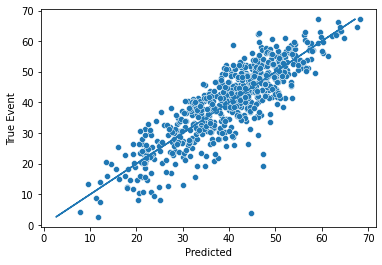

====> Train NLL: 541393.8627 	 Valid event loss: 266441.5185 	 censoring loss : 0.0000 	 Improved: *
epoch51
====> Train NLL: 546165.1273 	 Valid event loss: 267662.1024 	 censoring loss : 0.0000 	 Improved:  
epoch52
====> Train NLL: 539480.6921 	 Valid event loss: 271641.5926 	 censoring loss : 0.0000 	 Improved:  
epoch53
====> Train NLL: 535357.1707 	 Valid event loss: 268396.3529 	 censoring loss : 0.0000 	 Improved:  
epoch54
====> Train NLL: 540928.3970 	 Valid event loss: 265443.4886 	 censoring loss : 0.0000 	 Improved: *
epoch55
====> Train NLL: 530941.7980 	 Valid event loss: 267740.6946 	 censoring loss : 0.0000 	 Improved:  
epoch56
====> Train NLL: 540275.4856 	 Valid event loss: 266400.7993 	 censoring loss : 0.0000 	 Improved:  
epoch57
====> Train NLL: 537843.9155 	 Valid event loss: 269769.6619 	 censoring loss : 0.0000 	 Improved:  
epoch58
====> Train NLL: 536145.6377 	 Valid event loss: 263866.7430 	 censoring loss : 0.0000 	 Improved: *
epoch59
====> Train NLL: 53

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


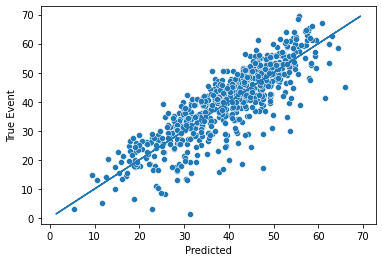

====> Train NLL: 531846.1702 	 Valid event loss: 263594.9669 	 censoring loss : 0.0000 	 Improved: *
epoch61
====> Train NLL: 529678.8711 	 Valid event loss: 262893.2801 	 censoring loss : 0.0000 	 Improved: *
epoch62
====> Train NLL: 529274.3284 	 Valid event loss: 261637.6746 	 censoring loss : 0.0000 	 Improved: *
epoch63
====> Train NLL: 540285.2793 	 Valid event loss: 260269.1275 	 censoring loss : 0.0000 	 Improved: *
epoch64
====> Train NLL: 529181.8343 	 Valid event loss: 261761.8131 	 censoring loss : 0.0000 	 Improved:  
epoch65
====> Train NLL: 529440.2943 	 Valid event loss: 266069.2325 	 censoring loss : 0.0000 	 Improved:  
epoch66
====> Train NLL: 527757.5140 	 Valid event loss: 261798.4515 	 censoring loss : 0.0000 	 Improved:  
epoch67
====> Train NLL: 522454.0410 	 Valid event loss: 261544.1178 	 censoring loss : 0.0000 	 Improved:  
epoch68
====> Train NLL: 524944.5180 	 Valid event loss: 261162.6186 	 censoring loss : 0.0000 	 Improved:  
epoch69
====> Train NLL: 52

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


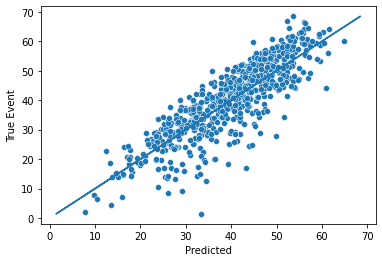

====> Train NLL: 524236.0854 	 Valid event loss: 256182.6565 	 censoring loss : 0.0000 	 Improved: *
epoch71
====> Train NLL: 523726.7115 	 Valid event loss: 260470.8158 	 censoring loss : 0.0000 	 Improved:  
epoch72
====> Train NLL: 520978.8504 	 Valid event loss: 256671.7737 	 censoring loss : 0.0000 	 Improved:  
epoch73
====> Train NLL: 519705.0004 	 Valid event loss: 257448.4160 	 censoring loss : 0.0000 	 Improved:  
epoch74
====> Train NLL: 520903.1165 	 Valid event loss: 261769.9620 	 censoring loss : 0.0000 	 Improved:  
epoch75
====> Train NLL: 520754.6394 	 Valid event loss: 258705.0626 	 censoring loss : 0.0000 	 Improved:  
epoch76
====> Train NLL: 517189.5548 	 Valid event loss: 258051.3841 	 censoring loss : 0.0000 	 Improved:  
epoch77
====> Train NLL: 517889.3785 	 Valid event loss: 256521.4847 	 censoring loss : 0.0000 	 Improved:  
epoch78
====> Train NLL: 519268.3692 	 Valid event loss: 256985.8725 	 censoring loss : 0.0000 	 Improved:  
epoch79
====> Train NLL: 51

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


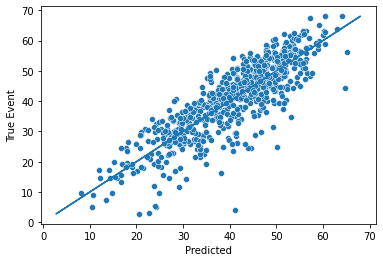

====> Train NLL: 513247.3480 	 Valid event loss: 257659.9314 	 censoring loss : 0.0000 	 Improved:  
epoch81
====> Train NLL: 510129.6823 	 Valid event loss: 257240.1763 	 censoring loss : 0.0000 	 Improved:  
epoch82
====> Train NLL: 519299.1724 	 Valid event loss: 255170.1509 	 censoring loss : 0.0000 	 Improved: *
epoch83
====> Train NLL: 513642.7312 	 Valid event loss: 254742.9703 	 censoring loss : 0.0000 	 Improved: *
epoch84
====> Train NLL: 511994.6780 	 Valid event loss: 256010.4563 	 censoring loss : 0.0000 	 Improved:  
epoch85
====> Train NLL: 511185.7584 	 Valid event loss: 254196.5095 	 censoring loss : 0.0000 	 Improved: *
epoch86
====> Train NLL: 513635.6797 	 Valid event loss: 255272.4292 	 censoring loss : 0.0000 	 Improved:  
epoch87
====> Train NLL: 511640.9831 	 Valid event loss: 255609.3785 	 censoring loss : 0.0000 	 Improved:  
epoch88
====> Train NLL: 513542.8392 	 Valid event loss: 254250.9130 	 censoring loss : 0.0000 	 Improved:  
epoch89
====> Train NLL: 51

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


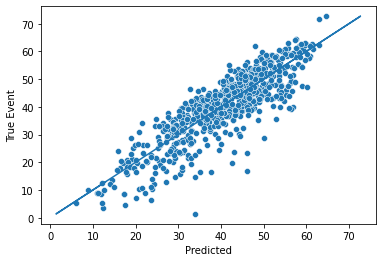

====> Train NLL: 507232.7499 	 Valid event loss: 252648.0330 	 censoring loss : 0.0000 	 Improved: *
epoch91
====> Train NLL: 513109.9297 	 Valid event loss: 253230.1281 	 censoring loss : 0.0000 	 Improved:  
epoch92
====> Train NLL: 508684.8282 	 Valid event loss: 255070.1805 	 censoring loss : 0.0000 	 Improved:  
epoch93
====> Train NLL: 507805.3529 	 Valid event loss: 253646.8962 	 censoring loss : 0.0000 	 Improved:  
epoch94
====> Train NLL: 504996.6000 	 Valid event loss: 251887.1922 	 censoring loss : 0.0000 	 Improved: *
epoch95
====> Train NLL: 506896.6122 	 Valid event loss: 251882.8234 	 censoring loss : 0.0000 	 Improved: *
epoch96
====> Train NLL: 504137.3751 	 Valid event loss: 252499.9551 	 censoring loss : 0.0000 	 Improved:  
epoch97
====> Train NLL: 506985.8242 	 Valid event loss: 250137.5334 	 censoring loss : 0.0000 	 Improved: *
epoch98
====> Train NLL: 501462.5595 	 Valid event loss: 254528.3051 	 censoring loss : 0.0000 	 Improved:  
epoch99
====> Train NLL: 50

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


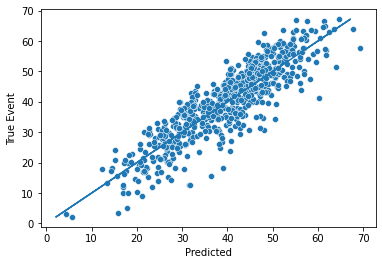

====> Train NLL: 499314.9944 	 Valid event loss: 251288.9294 	 censoring loss : 0.0000 	 Improved:  
epoch101
====> Train NLL: 504794.1161 	 Valid event loss: 249664.4759 	 censoring loss : 0.0000 	 Improved: *
epoch102
====> Train NLL: 506504.8393 	 Valid event loss: 252723.0414 	 censoring loss : 0.0000 	 Improved:  
epoch103
====> Train NLL: 501001.1931 	 Valid event loss: 250175.4388 	 censoring loss : 0.0000 	 Improved:  
epoch104
====> Train NLL: 506181.4320 	 Valid event loss: 252042.6891 	 censoring loss : 0.0000 	 Improved:  
epoch105
====> Train NLL: 502264.9438 	 Valid event loss: 250348.7863 	 censoring loss : 0.0000 	 Improved:  
epoch106
====> Train NLL: 496654.8138 	 Valid event loss: 250607.8748 	 censoring loss : 0.0000 	 Improved:  
epoch107
====> Train NLL: 500090.2505 	 Valid event loss: 250965.9437 	 censoring loss : 0.0000 	 Improved:  
epoch108
====> Train NLL: 499168.3849 	 Valid event loss: 250014.6127 	 censoring loss : 0.0000 	 Improved:  
epoch109
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


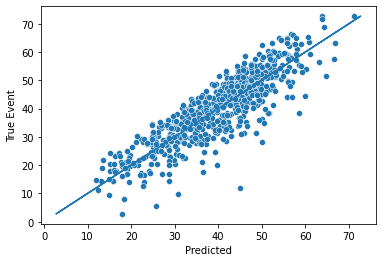

====> Train NLL: 500085.6783 	 Valid event loss: 252026.2031 	 censoring loss : 0.0000 	 Improved:  
epoch111
====> Train NLL: 500596.0883 	 Valid event loss: 249702.4989 	 censoring loss : 0.0000 	 Improved:  
epoch112
====> Train NLL: 499096.9099 	 Valid event loss: 248266.3944 	 censoring loss : 0.0000 	 Improved: *
epoch113
====> Train NLL: 498906.1859 	 Valid event loss: 251137.4866 	 censoring loss : 0.0000 	 Improved:  
epoch114
====> Train NLL: 494158.9773 	 Valid event loss: 249991.4503 	 censoring loss : 0.0000 	 Improved:  
epoch115
====> Train NLL: 497319.3980 	 Valid event loss: 247203.0260 	 censoring loss : 0.0000 	 Improved: *
epoch116
====> Train NLL: 497418.8640 	 Valid event loss: 250773.6543 	 censoring loss : 0.0000 	 Improved:  
epoch117
====> Train NLL: 498237.9615 	 Valid event loss: 248784.4444 	 censoring loss : 0.0000 	 Improved:  
epoch118
====> Train NLL: 497473.7268 	 Valid event loss: 247862.5586 	 censoring loss : 0.0000 	 Improved:  
epoch119
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


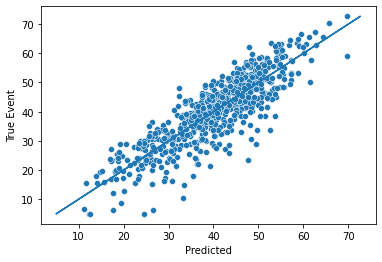

====> Train NLL: 492605.6796 	 Valid event loss: 248388.4810 	 censoring loss : 0.0000 	 Improved:  
epoch121
====> Train NLL: 497468.6124 	 Valid event loss: 249655.7359 	 censoring loss : 0.0000 	 Improved:  
epoch122
====> Train NLL: 496442.3928 	 Valid event loss: 251688.3491 	 censoring loss : 0.0000 	 Improved:  
epoch123
====> Train NLL: 494818.6958 	 Valid event loss: 249033.7757 	 censoring loss : 0.0000 	 Improved:  
epoch124
====> Train NLL: 496129.6342 	 Valid event loss: 251172.6072 	 censoring loss : 0.0000 	 Improved:  
epoch125
====> Train NLL: 497552.8096 	 Valid event loss: 247232.3578 	 censoring loss : 0.0000 	 Improved:  
epoch126
====> Train NLL: 493731.6146 	 Valid event loss: 246066.4939 	 censoring loss : 0.0000 	 Improved:  
epoch127
====> Train NLL: 493596.5973 	 Valid event loss: 248233.5405 	 censoring loss : 0.0000 	 Improved:  
epoch128
====> Train NLL: 492109.2462 	 Valid event loss: 245453.1998 	 censoring loss : 0.0000 	 Improved:  
epoch129
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


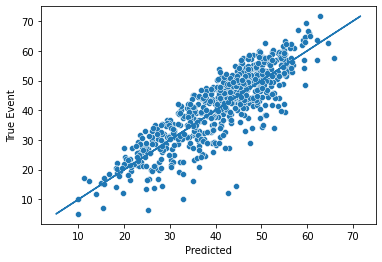

====> Train NLL: 491537.9022 	 Valid event loss: 248178.0750 	 censoring loss : 0.0000 	 Improved:  
epoch131
====> Train NLL: 492689.8339 	 Valid event loss: 247609.4656 	 censoring loss : 0.0000 	 Improved:  
epoch132
====> Train NLL: 491196.5407 	 Valid event loss: 248353.9523 	 censoring loss : 0.0000 	 Improved:  
epoch133
====> Train NLL: 489351.5392 	 Valid event loss: 249215.9143 	 censoring loss : 0.0000 	 Improved:  
epoch134
====> Train NLL: 490309.2493 	 Valid event loss: 247025.6591 	 censoring loss : 0.0000 	 Improved:  
epoch135
====> Train NLL: 488545.0055 	 Valid event loss: 247714.6285 	 censoring loss : 0.0000 	 Improved:  
epoch136
====> Train NLL: 492879.2349 	 Valid event loss: 247516.3122 	 censoring loss : 0.0000 	 Improved:  
epoch137
====> Train NLL: 489241.7385 	 Valid event loss: 246204.8951 	 censoring loss : 0.0000 	 Improved:  
epoch138
====> Train NLL: 490155.1715 	 Valid event loss: 246398.0950 	 censoring loss : 0.0000 	 Improved:  
epoch139
====> Trai

In [35]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_e_loss = 0
    valid_c_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
#     attention.train()
    decoder.train()
    for i, (x, y, e) in enumerate(pair1):
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb = embedding(x.float())
        z = attention(x_emb)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat-y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        loss = closs + eloss
    
        
#         y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)

        train_loss += loss.item()
        
        opt_emb.step()
#         opt_att.step()
        opt_dec.step()  
        
#     train_loss = train_loss/(i+1)     

    
    embedding.eval()
#     attention.eval()
    decoder.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb = embedding(x.float())
        z = attention(x_emb)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
#         valid_loss_ = eloss.item()

        valid_e_loss += eloss.item()
        valid_c_loss += closs.item()



#     valid_e_loss = valid_e_loss/(i+1)
#     valid_c_loss = valid_c_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_e_loss)
    
    save_model = 0
    if (best_valid_loss > valid_e_loss):
        save_model += 1
        
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure()
        
        sns.scatterplot(t_hat[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu().detach().numpy().squeeze())
        plt.plot(y[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu().detach().numpy().squeeze())
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# #         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()
    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_e_loss
        torch.save(embedding.state_dict(), emb_path)
#         torch.save(attention.state_dict(), att_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
    print('====> Train NLL: {:.4f} \t Valid event loss: {:.4f} \t censoring loss : {:.4f} \t Improved: {}'.format(train_loss, valid_e_loss,valid_c_loss,improved_str))

    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

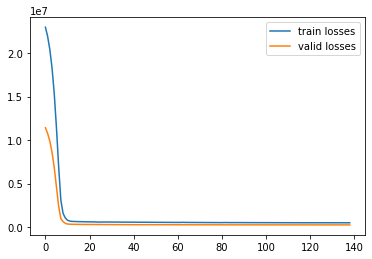

In [36]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()


In [37]:
embedding.load_state_dict(torch.load(emb_path))
decoder.load_state_dict(torch.load(dec_path))

for name, param in embedding.named_parameters():
    if param.requires_grad:
        print(name, param.data)

x_emb_landmarks.AGE tensor([[ 1.5147,  0.9382,  1.2153,  1.1262,  1.1589,  1.1038,  1.2090,  1.1306,
          1.0645,  1.1118],
        [ 0.1502,  1.1146,  0.6530,  0.6743,  0.7151,  0.7248,  0.7467,  0.7367,
          0.6651,  0.6276],
        [ 0.1970,  0.3346,  0.8955,  0.3361,  0.5405,  0.5687,  0.5007,  0.4828,
          0.5683,  0.4301],
        [ 0.1365,  0.3756,  0.2499,  0.7216,  0.3112,  0.4486,  0.4147,  0.3976,
          0.4705,  0.3188],
        [ 0.1154,  0.2665,  0.3094,  0.1213,  0.7658,  0.2830,  0.3094,  0.2681,
          0.3863,  0.2632],
        [ 0.0460,  0.1418,  0.1715,  0.1733,  0.1557,  0.7079,  0.1661,  0.1680,
          0.2633,  0.2090],
        [ 0.0360,  0.1040,  0.1244,  0.0615,  0.1269,  0.0563,  0.5947,  0.0886,
          0.2274,  0.0981],
        [-0.0549, -0.0367, -0.0249, -0.0425, -0.0281, -0.0530, -0.0728,  0.4664,
         -0.0098, -0.0115],
        [-0.0369, -0.0773, -0.0794, -0.0887, -0.0951, -0.0844, -0.0567, -0.1851,
          0.6847, -0.1873],

Text(0.5, 1.0, 'AGE embedding')

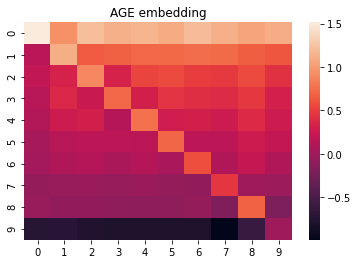

In [38]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

Text(0.5, 1.0, 'RANDON embedding')

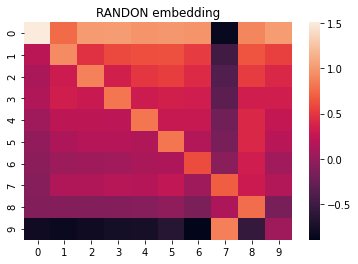

In [39]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

Text(0.5, 1.0, 'CAT0 embedding')

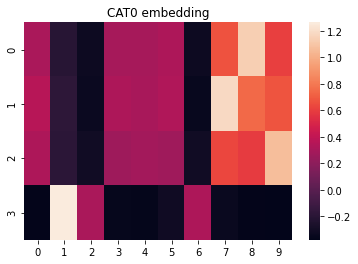

In [40]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

Text(0.5, 1.0, 'CAT1 embedding')

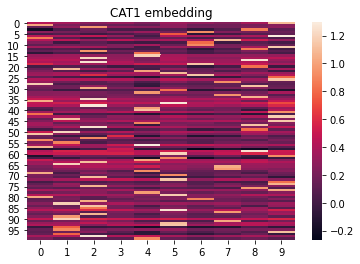

In [41]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

In [42]:
embedding.load_state_dict(torch.load(emb_path))
decoder.load_state_dict(torch.load(dec_path))

embedding.eval()
decoder.eval()
valid_e_loss = valid_c_loss= 0
valid_pred_t = []
valid_t = []
valid_e = []
for i, (x, y, e) in enumerate(v_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)        
    x_emb = embedding(x.float())
    z = attention(x_emb)
    t_hat = decoder(z)
    hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
    closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
    eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

    valid_e_loss += eloss.item()

    valid_c_loss += closs.item()
    
    valid_pred_t.append(t_hat.squeeze())
    valid_t.append(y.squeeze())
    valid_e.append(e.squeeze())

print(valid_e_loss)


249567.63244344055


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'True Event')

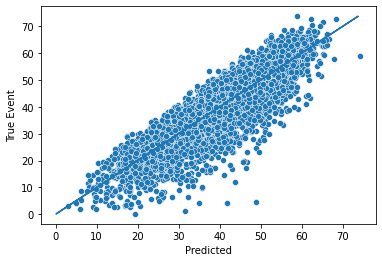

In [43]:
valid_e = torch.cat(valid_e)
valid_t = torch.cat(valid_t)
valid_pred_t = torch.cat(valid_pred_t)


subj = np.random.choice(len(valid_e))
plt.figure()

sns.scatterplot(valid_pred_t[valid_e==1].cpu().detach().numpy().squeeze(), valid_t[valid_e==1].cpu())
plt.plot(valid_t[valid_e==1].cpu(), valid_t[valid_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')
